In [397]:
import torch
import pandas as pd
import numpy as np
# pip install transformers
from transformers import BertTokenizer, BertModel
# 만약 주피터 노트북에서 아래와 관계있는 에러가 발생한다면
# pip install ipywidgets

In [398]:
main_df = pd.read_csv('/opt/ml/input/data/train/train_ratings.csv') # user-item-time
title_df = pd.read_csv('/opt/ml/input/data/train/titles.tsv', sep='\t') # item-title
year_df = pd.read_csv('/opt/ml/input/data/train/years.tsv', sep='\t') # item-year
director_df = pd.read_csv('/opt/ml/input/data/train/directors.tsv', sep='\t') # item-director
genre_name_df = pd.read_csv('/opt/ml/input/data/train/genres.tsv', sep='\t') # item-genre(name)
writer_df = pd.read_csv('/opt/ml/input/data/train/writers.tsv', sep='\t') # item-writer

In [399]:
# genres_df 생성
genres_df = pd.read_csv("/opt/ml/input/data/train/genres.tsv", sep="\t")
array, index = pd.factorize(genres_df["genre"])
genres_df["genre"] = array # item-genre(number)

# Genre Embedding

한 영화에 여러개의 장르가 있다.  
장르는 각각의 성질을 가지고 있다고 가정하고 (ex: "액션"과 "범죄"의 거리는 "액션"과 "드라마"의 거리보다 가깝다)  
각 단어들을 임베딩하여 숫자로 표현한다.
이때 각 단어는 크기가 약 760인 벡터로 임베딩 되는데 이 760개의 성분의 평균을 <U>**장르의 임베딩값**</U>으로 설정했다

여러 장르를 동시에 갖는 영화는 해당 장르들의 임베딩 값의 평균으로 설정하였다

In [13]:
# Load the BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

genre_vectors = {} # 각 장르의 임베딩 dict

# Tokenize a genre
for i,j in enumerate(genre_name_df['genre'].unique()):
    input_ids = torch.tensor(tokenizer.encode(f"{j}")).unsqueeze(0)  # Tokenize a genre
    output = model(input_ids)[0]  # Extract the hidden states of the model at the last layer, The last layer hidden states
    token_embedding = output[0][0]  # Extract the first token's embedding
    np_token_embedding = token_embedding.detach().numpy() # convert to numpy
    v = np_token_embedding.mean()
    genre_vectors[i] = v

ref_genre_dict = {} # 각 영화가 어떤 장르를 가지고 있는지 나타내는 dict
for i, j in list(zip(genres_df['item'], genres_df['genre'])):
    try:
        ref_genre_dict[i].append(j)
    except KeyError:
        ref_genre_dict[i] = [j]

genre_df_dict = {} # 각 영화의 장르 통합 임베딩 dict
for i, j in list(zip(ref_genre_dict.keys(), ref_genre_dict.values())):
    genre_df_dict[i] = 0
    for k in j:
        genre_df_dict[i] += genre_vectors[k]
    genre_df_dict[i] = (genre_df_dict[i])/len(j)

# 데이터 프레임에 적용
ref_df = main_df.copy()
ref_df['item_2'] = ref_df['item']
ref_df.item_2 = ref_df.item_2.map(genre_df_dict)
ref_df = ref_df.rename(columns={'item_2':'genre_embedding'})
ref_df

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,user,item,time,genre_embedding
0,11,4643,1230782529,-0.009958
1,11,170,1230782534,-0.010141
2,11,531,1230782539,-0.010972
3,11,616,1230782542,-0.010493
4,11,2140,1230782563,-0.010183
...,...,...,...,...
5154466,138493,44022,1260209449,-0.010516
5154467,138493,4958,1260209482,-0.010298
5154468,138493,68319,1260209720,-0.009911
5154469,138493,40819,1260209726,-0.010697


아래는 모든 피쳐를 한곳에 모은 데이터 프레임이다

In [14]:
ref_df = pd.merge(ref_df, year_df, on='item', how='left')
ref_df = pd.merge(ref_df, title_df, on='item', how='left')

# 제목의 연도로 연도 결측치 제거
import re
ref_df['year_from_title'] = ref_df['title'].apply(lambda x : (x[-5:-1]))
# 007-을 2007로 변경
ref_df.loc[ref_df['year_from_title']=='007-','year_from_title'] = 2007
# year가 결측치인 곳에 삽입
ref_df.loc[ref_df['year'].isnull(),'year'] = ref_df.loc[ref_df['year'].isnull(),'year_from_title'].astype('float')

ref_df

,user,item,time,genre_embedding,year,title,year_from_title
0,11,4643,1230782529,-0.009958,2001.0,Planet of the Apes (2001),2001
1,11,170,1230782534,-0.010141,1995.0,Hackers (1995),1995
2,11,531,1230782539,-0.010972,1993.0,"Secret Garden, The (1993)",1993
3,11,616,1230782542,-0.010493,1970.0,"Aristocats, The (1970)",1970
4,11,2140,1230782563,-0.010183,1982.0,"Dark Crystal, The (1982)",1982
...,...,...,...,...,...,...,...
5154466,138493,44022,1260209449,-0.010516,2006.0,Ice Age 2: The Meltdown (2006),2006
5154467,138493,4958,1260209482,-0.010298,2001.0,Behind Enemy Lines (2001),2001
5154468,138493,68319,1260209720,-0.009911,2009.0,X-Men Origins: Wolverine (2009),2009
5154469,138493,40819,1260209726,-0.010697,2005.0,Walk the Line (2005),2005


In [15]:
ref_df.isna().sum()

user               0
item               0
time               0
genre_embedding    0
year               0
title              0
year_from_title    0
dtype: int64

director와 writer의 결측치는 각각 약 1/7 수준이라 통합데이터에 노이즈를 우려하여 합치지 않았다

- writer  
6807개의 영화 중 5648개만 작가 정보가 있다  
결측치 1159

- director  
6807개의 영화 중 5503개만 감독 정보가 있다  
결측치 1304



In [19]:
ref_df = ref_df.drop(['year_from_title'],axis=1)

In [128]:
ref_df.to_csv(
    "uitgyt.csv", index=False
)

# Director Embedding
director_df의 결측행, 중복행을 해결하기 ---> director의 행길이 : 6807

In [170]:
# director_df에 없는 영화정보를 director를 'nm0000000'으로해서 뒤에 추가 -> director_df['director'].ninuque() == 6807

In [303]:
no_dir_item_list = list(set(main_df['item']) - set(director_df['item']))

In [304]:
no_dir_item_df = pd.DataFrame([x for x in zip(no_dir_item_list, ['nm0000000']*len(no_dir_item_list))])

In [305]:
no_dir_item_df.columns=director_df.columns # 컬럼명 동일하게

In [306]:
director_df = pd.concat([director_df, no_dir_item_df]) # 기존 director_df 뒤에 감독없는 영화 추가

In [307]:
director_df

,item,director
0,1237,nm0000005
1,5147,nm0000005
2,7327,nm0000005
3,2068,nm0000005
4,7396,nm0000005
...,...,...
1299,73681,nm0000000
1300,32728,nm0000000
1301,32743,nm0000000
1302,106491,nm0000000


In [308]:
dir_df = ref_df.merge(director_df, how='left')

In [309]:
dir_df

,user,item,time,genre_embedding,year,title,director
0,11,4643,1230782529,-0.009958,2001.0,Planet of the Apes (2001),nm0000318
1,11,170,1230782534,-0.010141,1995.0,Hackers (1995),nm0812200
2,11,531,1230782539,-0.010972,1993.0,"Secret Garden, The (1993)",nm0002140
3,11,616,1230782542,-0.010493,1970.0,"Aristocats, The (1970)",nm0718627
4,11,2140,1230782563,-0.010183,1982.0,"Dark Crystal, The (1982)",nm0000568
...,...,...,...,...,...,...,...
5708948,138493,44022,1260209449,-0.010516,2006.0,Ice Age 2: The Meltdown (2006),nm0757858
5708949,138493,4958,1260209482,-0.010298,2001.0,Behind Enemy Lines (2001),nm0601382
5708950,138493,68319,1260209720,-0.009911,2009.0,X-Men Origins: Wolverine (2009),nm0004303
5708951,138493,40819,1260209726,-0.010697,2005.0,Walk the Line (2005),nm0003506


In [310]:
ref_df.isna().sum()

user               0
item               0
time               0
genre_embedding    0
year               0
title              0
dtype: int64

In [311]:
item_list = director_df[director_df['director'] == 'nm0000005']['item'].tolist()

In [312]:
item_list

[1237,
 5147,
 7327,
 2068,
 7396,
 7820,
 4422,
 7939,
 7938,
 7941,
 7937,
 2131,
 34155,
 7936,
 7940,
 7577,
 7942,
 8405,
 7328]

In [313]:
len(dir_df[dir_df['item'].isin(item_list)])

6360

In [147]:
# #감독별 받은 총 interaction 수 정보
# director_list = dir_df['director'].unique()
# director_dict = {}
# for name in director_list:
#     dir_item_list = director_df[director_df['director'] == name]['item'].tolist()   #해당 감독이 기여한 영화 리스트
#     director_dict[name] = len(dir_df[dir_df['item'].isin(dir_item_list)])           #해당 감독이 기여한 영화들의 총 interaction 수

In [314]:
#감독별 받은 총 interaction 수 정보 / 감독이 기여한 영화수
director_list = dir_df['director'].unique()
director_dict = {}
for name in director_list:
    dir_item_list = director_df[director_df['director'] == name]['item'].tolist()   #해당 감독이 기여한 영화 리스트
    director_dict[name] = len(dir_df[dir_df['item'].isin(dir_item_list)]) / (len(dir_item_list)+1)      #해당 감독이 기여한 영화들의 총 interaction 수

In [315]:
director_dict

{'nm0000318': 2859.4444444444443,
 'nm0812200': 583.7142857142857,
 'nm0002140': 430.3333333333333,
 'nm0718627': 1966.076923076923,
 'nm0000568': 824.3076923076923,
 'nm0001345': 1399.75,
 'nm0001317': 511.07142857142856,
 'nm0000186': 1423.8181818181818,
 'nm0922346': 675.5714285714286,
 'nm0001675': 3917.133333333333,
 'nm0001382': 173.66666666666666,
 'nm0000000': 230.99233716475095,
 'nm0000343': 797.0,
 'nm0730422': 224.33333333333334,
 'nm0432627': 952.0,
 'nm0000386': 1700.5454545454545,
 'nm0205157': 280.6666666666667,
 'nm0378893': 636.0,
 'nm0000416': 4461.615384615385,
 'nm0145336': 88.0,
 'nm0935095': 235.83333333333334,
 'nm0405632': 330.6666666666667,
 'nm0281945': 438.25,
 'nm0000965': 2549.0,
 'nm0294379': 701.0,
 'nm0811583': 1948.7142857142858,
 'nm0499724': 611.5714285714286,
 'nm0031976': 1898.4,
 'nm0781842': 886.1111111111111,
 'nm0935863': 170.0909090909091,
 'nm0027271': 497.5,
 'nm0833779': 186.0,
 'nm0833780': 186.0,
 'nm0919363': 3031.3333333333335,
 'nm0919

In [316]:
director_df[director_df['item'] == 1237]

,item,director
0,1237,nm0000005


In [317]:
director_df['director_inter'] = director_df['director'].map(director_dict)

In [318]:
director_df

,item,director,director_inter
0,1237,nm0000005,318.000000
1,5147,nm0000005,318.000000
2,7327,nm0000005,318.000000
3,2068,nm0000005,318.000000
4,7396,nm0000005,318.000000
...,...,...,...
1299,73681,nm0000000,230.992337
1300,32728,nm0000000,230.992337
1301,32743,nm0000000,230.992337
1302,106491,nm0000000,230.992337


In [319]:
director_df[director_df['item']==1]

,item,director,director_inter
2374,1,nm0005124,7436.166667


In [320]:
df = director_df.groupby('item')['director_inter'].max() # 한 아이템당 여러 감독이 참여했을 때, 감독들의 평균(interaction/movie_cnt) 평점중 가장 큰 수

In [321]:
df

item
1         7436.166667
2         1105.000000
3          373.250000
4           67.000000
5          349.800000
             ...     
118700     230.992337
118900     316.000000
118997     774.166667
119141     316.000000
119145    1856.500000
Name: director_inter, Length: 6807, dtype: float64

In [323]:
director_df = director_df.merge(df, how='left', on='item')
director_df

,item,director,director_inter_x,director_inter_y
0,1237,nm0000005,318.000000,318.000000
1,5147,nm0000005,318.000000,318.000000
2,7327,nm0000005,318.000000,318.000000
3,2068,nm0000005,318.000000,318.000000
4,7396,nm0000005,318.000000,318.000000
...,...,...,...,...
7204,73681,nm0000000,230.992337,230.992337
7205,32728,nm0000000,230.992337,230.992337
7206,32743,nm0000000,230.992337,230.992337
7207,106491,nm0000000,230.992337,230.992337


In [325]:
director_df[director_df['item']==25764] #한 영화에 2명의 감독 기여한 case 확인

,item,director,director_inter_x,director_inter_y,director_info
65,25764,nm0000036,218.111111,218.111111,218.111111
4995,25764,nm0781292,123.000000,218.111111,218.111111


In [326]:
director_df['director_info'] = director_df['director_inter_y']

In [327]:
director_df.drop_duplicates(
        subset=["item"], keep="first", inplace=True)

In [328]:
director_df

,item,director,director_inter_x,director_inter_y,director_info
0,1237,nm0000005,318.000000,318.000000,318.000000
1,5147,nm0000005,318.000000,318.000000,318.000000
2,7327,nm0000005,318.000000,318.000000,318.000000
3,2068,nm0000005,318.000000,318.000000,318.000000
4,7396,nm0000005,318.000000,318.000000,318.000000
...,...,...,...,...,...
7204,73681,nm0000000,230.992337,230.992337,230.992337
7205,32728,nm0000000,230.992337,230.992337,230.992337
7206,32743,nm0000000,230.992337,230.992337,230.992337
7207,106491,nm0000000,230.992337,230.992337,230.992337


In [431]:
!pwd

/opt/ml/input/fighting/FE


In [329]:
director_df[['item','director_info']].to_csv(
    "director_fe.csv", index=False
)

In [330]:
director_df[director_df['item']==5147]

,item,director,director_inter_x,director_inter_y,director_info
1,5147,nm0000005,318.0,318.0,318.0


# writer embedding

In [368]:
writer_df

,item,writer
0,1237,nm0000005
1,5147,nm0000005
2,7327,nm0000005
3,2068,nm0000005
4,7396,nm0000005
...,...,...
11301,27397,nm5371819
11302,2987,nm5927607
11303,33463,nm5927607
11304,2987,nm5927608


In [369]:
# writer_df에 없는 영화정보를 director를 'nm0000000'으로해서 뒤에 추가 -> director_df['director'].ninuque() == 6807

In [370]:
no_wri_item_list = list(set(main_df['item']) - set(writer_df['item']))

In [371]:
no_wri_item_df = pd.DataFrame([x for x in zip(no_wri_item_list, ['nm0000000']*len(no_wri_item_list))])

In [372]:
no_wri_item_df.columns=writer_df.columns # 컬럼명 동일하게

In [373]:
writer_df = pd.concat([writer_df, no_wri_item_df]) # 기존 director_df 뒤에 감독없는 영화 추가

In [374]:
writer_df

,item,writer
0,1237,nm0000005
1,5147,nm0000005
2,7327,nm0000005
3,2068,nm0000005
4,7396,nm0000005
...,...,...
1154,55284,nm0000000
1155,81910,nm0000000
1156,4091,nm0000000
1157,2046,nm0000000


In [375]:
wri_df = ref_df.merge(writer_df, how='left')

In [376]:
wri_df

,user,item,time,genre_embedding,year,title,writer
0,11,4643,1230782529,-0.009958,2001.0,Planet of the Apes (2001),nm0099541
1,11,4643,1230782529,-0.009958,2001.0,Planet of the Apes (2001),nm0115310
2,11,4643,1230782529,-0.009958,2001.0,Planet of the Apes (2001),nm0465199
3,11,4643,1230782529,-0.009958,2001.0,Planet of the Apes (2001),nm0742797
4,11,170,1230782534,-0.010141,1995.0,Hackers (1995),nm0000000
...,...,...,...,...,...,...,...
11591602,138493,68319,1260209720,-0.009911,2009.0,X-Men Origins: Wolverine (2009),nm1125275
11591603,138493,40819,1260209726,-0.010697,2005.0,Walk the Line (2005),nm0003506
11591604,138493,40819,1260209726,-0.010697,2005.0,Walk the Line (2005),nm0219456
11591605,138493,27311,1260209807,-0.009940,2000.0,Batman Beyond: Return of the Joker (2000),nm0004170


In [377]:
wri_df.isna().sum()

user               0
item               0
time               0
genre_embedding    0
year               0
title              0
writer             0
dtype: int64

In [378]:
item_list = writer_df[writer_df['writer'] == 'nm0000005']['item'].tolist()

In [379]:
item_list

[1237,
 5147,
 7327,
 2068,
 7396,
 4422,
 7939,
 7938,
 7941,
 7937,
 2131,
 34155,
 7936,
 7940,
 7577,
 7942,
 8405,
 7328]

In [380]:
len(wri_df[wri_df['item'].isin(item_list)])

6020

In [381]:
# #감독별 받은 총 interaction 수 정보
# director_list = dir_df['director'].unique()
# director_dict = {}
# for name in director_list:
#     dir_item_list = director_df[director_df['director'] == name]['item'].tolist()   #해당 감독이 기여한 영화 리스트
#     director_dict[name] = len(dir_df[dir_df['item'].isin(dir_item_list)])           #해당 감독이 기여한 영화들의 총 interaction 수

In [382]:
#각본가별 받은 총 interaction 수 정보 / 각본가가 기여한 영화수
writer_list = wri_df['writer'].unique()
writer_dict = {}
for name in writer_list:
    wri_item_list = writer_df[writer_df['writer'] == name]['item'].tolist()   #해당 각본가가 기여한 영화 리스트
    writer_dict[name] = len(wri_df[wri_df['item'].isin(wri_item_list)]) / (len(wri_item_list)+1)      #해당 각본가가 기여한 영화들의 총 interaction 수

In [383]:
writer_dict

{'nm0099541': 3076.8,
 'nm0115310': 4146.333333333333,
 'nm0465199': 1764.1,
 'nm0742797': 1764.1,
 'nm0000000': 269.56206896551726,
 'nm0003031': 5684.0,
 'nm0122364': 1005.0,
 'nm0027011': 6646.0,
 'nm0166307': 4469.4,
 'nm0166551': 4113.2,
 'nm0314788': 5445.076923076923,
 'nm0841035': 4465.6,
 'nm0858826': 5361.5,
 'nm0942723': 5794.0,
 'nm0001345': 2081.0,
 'nm0643973': 1036.3333333333333,
 'nm0694526': 4391.666666666667,
 'nm0694638': 4391.666666666667,
 'nm0000186': 2345.8,
 'nm0075015': 2182.0,
 'nm0212246': 1913.25,
 'nm0001279': 1925.0,
 'nm0078203': 413.6666666666667,
 'nm0932078': 616.3333333333334,
 'nm0549256': 967.0,
 'nm0568416': 159.25,
 'nm0000343': 1097.909090909091,
 'nm0083348': 9723.333333333334,
 'nm0308376': 1043.75,
 'nm0534681': 1574.7777777777778,
 'nm0730422': 3172.8571428571427,
 'nm0934093': 1574.7777777777778,
 'nm0000636': 1335.888888888889,
 'nm0527581': 2354.714285714286,
 'nm0809006': 2354.714285714286,
 'nm0000386': 4530.571428571428,
 'nm0460057': 7

In [384]:
writer_df[writer_df['item'] == 1237]

,item,writer
0,1237,nm0000005


In [385]:
writer_df['writer_inter'] = writer_df['writer'].map(writer_dict)

In [386]:
writer_df

,item,writer,writer_inter
0,1237,nm0000005,316.842105
1,5147,nm0000005,316.842105
2,7327,nm0000005,316.842105
3,2068,nm0000005,316.842105
4,7396,nm0000005,316.842105
...,...,...,...
1154,55284,nm0000000,269.562069
1155,81910,nm0000000,269.562069
1156,4091,nm0000000,269.562069
1157,2046,nm0000000,269.562069


In [387]:
writer_df[writer_df['item']==1]

,item,writer,writer_inter
1942,1,nm0004056,28383.800000
2053,1,nm0005124,23612.714286
3512,1,nm0169505,15000.500000
3953,1,nm0230032,33020.428571
8254,1,nm0710020,42629.777778
9236,1,nm0812513,15000.500000
10205,1,nm0923736,10687.909091


In [388]:
df = writer_df.groupby('item')['writer_inter'].max()

In [389]:
df

item
1         42629.777778
2          5837.125000
3           510.625000
4          1336.307692
5          2538.818182
              ...     
118700      269.562069
118900     5791.285714
118997       96.000000
119141     1974.125000
119145     7050.285714
Name: writer_inter, Length: 6807, dtype: float64

In [390]:
writer_df[writer_df['item']==25764]

,item,writer,writer_inter
2841,25764,nm0090213,3067.000
3099,25764,nm0115669,653.875
4238,25764,nm0267868,245.750
6655,25764,nm0513858,296.000
7422,25764,nm0604526,230.000


In [391]:
writer_df = writer_df.merge(df, how='left', on='item')
writer_df

,item,writer,writer_inter_x,writer_inter_y
0,1237,nm0000005,316.842105,316.842105
1,5147,nm0000005,316.842105,316.842105
2,7327,nm0000005,316.842105,316.842105
3,2068,nm0000005,316.842105,316.842105
4,7396,nm0000005,316.842105,316.842105
...,...,...,...,...
12460,55284,nm0000000,269.562069,269.562069
12461,81910,nm0000000,269.562069,269.562069
12462,4091,nm0000000,269.562069,269.562069
12463,2046,nm0000000,269.562069,269.562069


In [392]:
writer_df['writer_info'] = writer_df['writer_inter_y']

In [393]:
writer_df.drop_duplicates(
        subset=["item"], keep="first", inplace=True)

In [394]:
writer_df

,item,writer,writer_inter_x,writer_inter_y,writer_info
0,1237,nm0000005,316.842105,316.842105,316.842105
1,5147,nm0000005,316.842105,316.842105,316.842105
2,7327,nm0000005,316.842105,316.842105,316.842105
3,2068,nm0000005,316.842105,316.842105,316.842105
4,7396,nm0000005,316.842105,316.842105,316.842105
...,...,...,...,...,...
12460,55284,nm0000000,269.562069,269.562069,269.562069
12461,81910,nm0000000,269.562069,269.562069,269.562069
12462,4091,nm0000000,269.562069,269.562069,269.562069
12463,2046,nm0000000,269.562069,269.562069,269.562069


In [395]:
writer_df[['item','writer_info']].to_csv(
    "writer_fe.csv", index=False
)

In [396]:
writer_df[writer_df['item']==5147]

,item,writer,writer_inter_x,writer_inter_y,writer_info
1,5147,nm0000005,316.842105,316.842105,316.842105


# 유저가 가장 좋아하는 장르 FE

In [402]:
genres_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15933 entries, 0 to 15932
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   item    15933 non-null  int64
 1   genre   15933 non-null  int64
dtypes: int64(2)
memory usage: 249.1 KB


In [404]:
genres_df.nunique()

item     6807
genre      18
dtype: int64

In [406]:
main_df.head(3)

,user,item,time
0,11,4643,1230782529
1,11,170,1230782534
2,11,531,1230782539


In [419]:
genres_df['genre2'] = genres_df['genre']

In [430]:
user_tag_pivot

genre2,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
item,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,8.0,9.0,0.0,0.0,12.0,13.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,9.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118700,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118900,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118997,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,13.0,0.0,15.0,0.0,0.0


<AxesSubplot: xlabel='tsne_component_1', ylabel='tsne_component_2'>

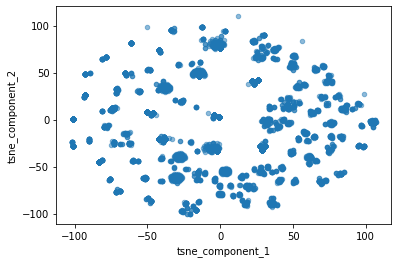

In [429]:
import hdbscan
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN

user_tag_pivot = genres_df.pivot_table(values="genre", index="item", columns="genre2").fillna(0)
tsne = TSNE(n_components=2, random_state=42)
tsne_user_result = tsne.fit_transform(user_tag_pivot.values)
tsne_user_df = pd.DataFrame(tsne_user_result, columns=['tsne_component_1', 'tsne_component_2'])
tsne_user_df.plot(kind='scatter',x='tsne_component_1', y='tsne_component_2',alpha=0.5)